# Predicting Who Will Survive on the Titanic

In [1]:
#Run once to install the required packages
!pip install -U scikit-learn
!pip install wget

Requirement already up-to-date: scikit-learn in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: wget in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn')

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Acquire data

The Python Pandas packages helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [3]:
import wget
url_train='https://github.com/mlhubca/lab/raw/master/titanic/train.csv'
url_test='https://github.com/mlhubca/lab/raw/master/titanic/test.csv'

#remove existing files before downloading
!rm -f train.csv
!rm -f test.csv

trainFilename=wget.download(url_train)
testFilename=wget.download(url_test)

train_df = pd.read_csv(trainFilename)
test_df = pd.read_csv(testFilename)
combine = [train_df, test_df]

## Analyze by describing data

Pandas also helps describe the datasets answering following questions early in our project.

**Which features are available in the dataset?**

Noting the feature names for directly manipulating or analyzing these. These feature names are described on the [Kaggle data page here](https://www.kaggle.com/c/titanic/data).

In [4]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. 
- Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. 
- Discrete: SibSp, Parch.

In [5]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Which features are mixed data types?**

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

**Which features may contain errors or typos?**

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [6]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

In [7]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

**What is the distribution of numerical feature values across the samples?**

This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

In [8]:
train_df.describe()
# Review survived rate using `percentiles=[.61, .62]` knowing our problem description mentions 38% survival rate.
# Review Parch distribution using `percentiles=[.75, .8]`
# SibSp distribution `[.68, .69]`
# Age and Fare `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**What is the distribution of categorical features?**

- Names are unique across the dataset (count=unique=891)
- Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
- Cabin values have several duplicates across samples. Alternatively several passengers shared a cabin.
- Embarked takes three possible values. S port used by most passengers (top=S)
- Ticket feature has high ratio (22%) of duplicate values (unique=681).

In [9]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",male,1601,G6,S
freq,1,577,7,4,644


### Assumptions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

**Correlating.**

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

**Completing.**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**Correcting.**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**Creating.**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.

**Classifying.**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived. 
3. The upper-class passengers (Pclass=1) were more likely to have survived.

## Analyze by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [10]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [11]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [12]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [13]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data

Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features

Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

**Observations.**

- Infants (Age <=4) had high survival rate.
- Oldest passengers (Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**Decisions.**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

- We should consider Age (our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3).

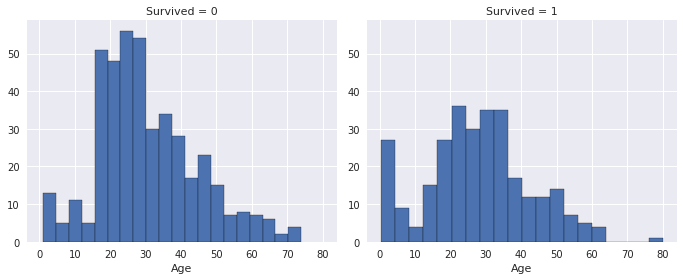

In [20]:
g = sns.FacetGrid(train_df, col='Survived',size=4,aspect=1.2)
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features

We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

**Observations.**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**Decisions.**

- Consider Pclass for model training.

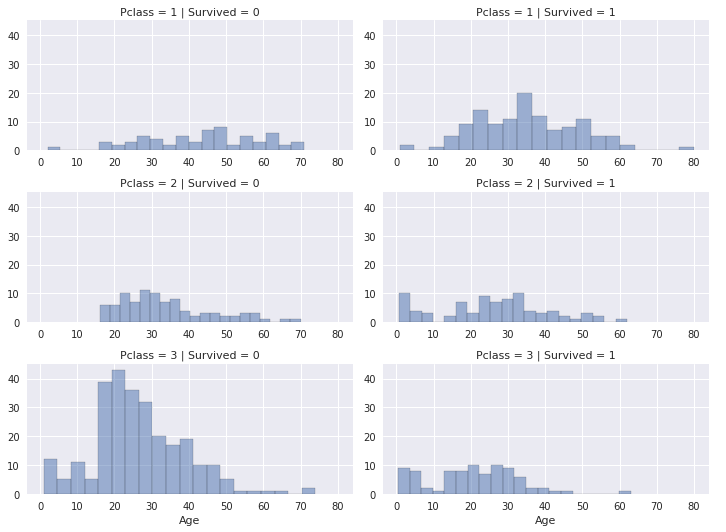

In [22]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.5, aspect=2)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features

Now we can correlate categorical features with our solution goal.

**Observations.**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between `Pclass` and `Embarked` and in turn between `Pclass` and `Survived`, not necessarily direct correlation between `Embarked` and `Survived`.
- Males had better survival rate in `Pclass=3` when compared with `Pclass=2` for `C` and `Q` ports. Completing (#2).
- Ports of embarkation have varying survival rates for `Pclass=3` and among male passengers. Correlating (#1).

**Decisions.**

- Add `Sex` feature to model training.
- Complete and add `Embarked` feature to model training.

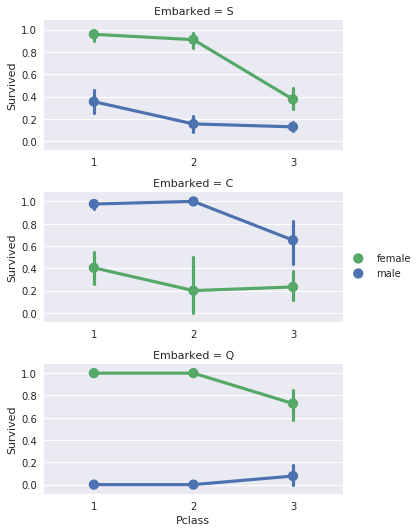

In [23]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.5, aspect=2)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correlating categorical and numerical features

We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

**Observations.**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**Decisions.**

- Consider banding Fare feature.

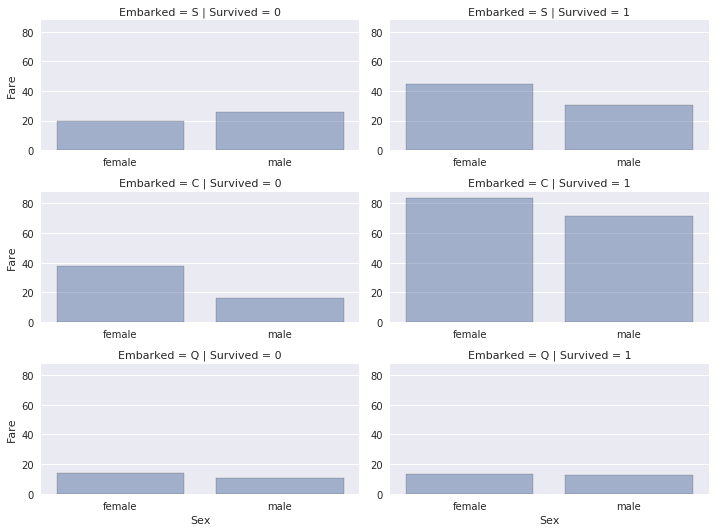

In [24]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.5, aspect=2)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Wrangle data

We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

### Correcting by dropping features

This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [25]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


### Creating new feature extracting from existing

We want to analyze if `Name` feature can be engineered to extract titles and test correlation between titles and survival, before dropping `Name` and `PassengerId` features.

In the following code we extract `Title` feature using regular expressions. The RegEx pattern `' ([A-Za-z]+)\.'` matches the first word which ends with a dot character within `Name` feature. The `expand=False` flag returns a DataFrame.

**Observations.**

When we plot `Title`, `Age`, and `Survived`, we note the following observations.

- Most titles band `Age` groups accurately. For example: `Master` title has `Age` mean of 5 years.
- `Survival` among Title Age bands varies slightly.
- Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision.**

- We decide to retain the new Title feature for model training.

In [26]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as `Rare`.

In [27]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


We can use the `Pandas.get_dummies()` function to one-hot encode the titles

In [28]:
train_df = train_df.join(pd.get_dummies(train_df['Title']))
test_df = test_df.join(pd.get_dummies(test_df['Title']))

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Master,Miss,Mr,Mrs,Rare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,0,0,1,0,0


Now we can safely drop the `Name` and `Title` feature from training and testing datasets. We also do not need the `PassengerId` feature.

In [29]:
train_df = train_df.drop(['Name', 'Title', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name', 'Title', 'PassengerId'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 13), (418, 12))

### Converting a categorical feature

Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting `Sex` feature to a new feature called `Gender` where `female=1` and `male=0`.

In [30]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22.0,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38.0,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26.0,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35.0,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35.0,0,0,8.0500,S,0,0,1,0,0


### Completing a numerical continuous feature

Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

1. A simple way is to generate random numbers between mean and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).

2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among `Age`, `Gender`, and `Pclass`. Guess `Age` values using [median](https://en.wikipedia.org/wiki/Median) values for `Age` across sets of `Pclass` and `Gender` feature combinations. So, median `Age` for `Pclass=1` and `Gender=0`, `Pclass=1` and `Gender=1`, and so on...

3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of `Pclass` and `Gender` combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

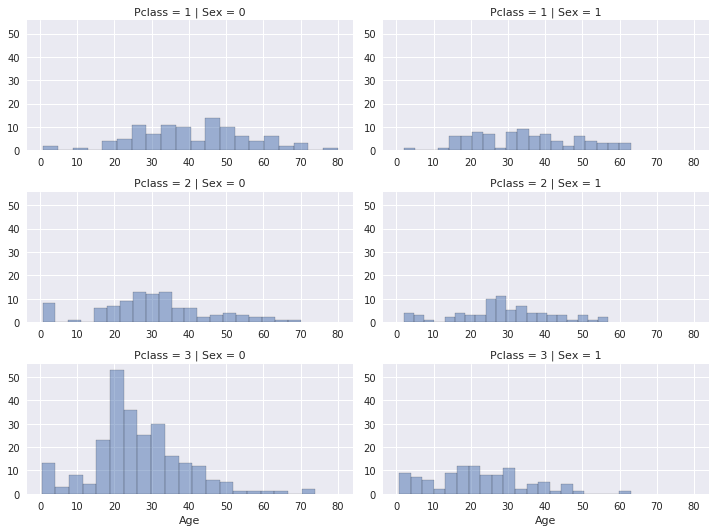

In [33]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.5, aspect=2)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on `Pclass x Gender` combinations.

In [34]:
guess_ages = np.zeros((2,3))
guess_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [35]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,22,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,38,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,26,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,35,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,35,0,0,8.0500,S,0,0,1,0,0


Let us create Age bands and determine correlations with Survived.

In [36]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Let us replace Age with ordinals based on these bands.

In [37]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,AgeBand
0,0,3,0,1,1,0,7.2500,S,0,0,1,0,0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,0,0,0,1,0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,0,1,0,0,0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,0,0,0,1,0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,0,0,1,0,0,"(32.0, 48.0]"


We can not remove the AgeBand feature.

In [38]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Master,Miss,Mr,Mrs,Rare
0,0,3,0,1,1,0,7.2500,S,0,0,1,0,0
1,1,1,1,2,1,0,71.2833,C,0,0,0,1,0
2,1,3,1,1,0,0,7.9250,S,0,1,0,0,0
3,1,1,1,2,1,0,53.1000,S,0,0,0,1,0
4,0,3,0,2,0,0,8.0500,S,0,0,1,0,0


### Create new feature combining existing features

We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [39]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [40]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [41]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone
0,0,3,0,1,7.2500,S,0,0,1,0,0,0
1,1,1,1,2,71.2833,C,0,0,0,1,0,0
2,1,3,1,1,7.9250,S,0,1,0,0,0,1
3,1,1,1,2,53.1000,S,0,0,0,1,0,0
4,0,3,0,2,8.0500,S,0,0,1,0,0,1


We can also create an artificial feature combining Pclass and Age.

In [42]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [43]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [44]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric

We can now convert the EmbarkedFill feature by creating new dummies for Port of departure feature.

In [45]:
train_df = train_df.join(pd.get_dummies(train_df['Embarked'], prefix='Port'))
test_df = test_df.join(pd.get_dummies(test_df['Embarked'], prefix='Port'))

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,Port_C,Port_Q,Port_S
0,0,3,0,1,7.2500,S,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,71.2833,C,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,7.9250,S,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,53.1000,S,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,8.0500,S,0,0,1,0,0,1,6,0,0,1


Now we can drop the Embarked feature

In [46]:
train_df = train_df.drop(['Embarked'], axis=1)
test_df = test_df.drop(['Embarked'], axis=1)

### Quick completing and converting a numeric feature

We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [47]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,Port_C,Port_Q,Port_S
0,3,0,2,7.8292,0,0,1,0,0,1,6,0,1,0
1,3,1,2,7.0000,0,0,0,1,0,0,6,0,0,1
2,2,0,3,9.6875,0,0,1,0,0,1,6,0,1,0
3,3,0,1,8.6625,0,0,1,0,0,1,3,0,0,1
4,3,1,1,12.2875,0,0,0,1,0,0,3,0,0,1


We can now create FareBand.

In [48]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [49]:
for dataset in combine:
    dataset['Fare'].fillna(dataset['Fare'].dropna().median(), inplace=True)

Convert the Fare feature to ordinal values based on the FareBand.

In [50]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,Port_C,Port_Q,Port_S
0,0,3,0,1,7.2500,0,0,1,0,0,0,3,0,0,1
1,1,1,1,2,71.2833,0,0,0,1,0,0,2,1,0,0
2,1,3,1,1,7.9250,0,1,0,0,0,1,3,0,0,1
3,1,1,1,2,53.1000,0,0,0,1,0,0,2,0,0,1
4,0,3,0,2,8.0500,0,0,1,0,0,1,6,0,0,1
5,0,3,0,1,8.4583,0,0,1,0,0,1,3,0,1,0
6,0,1,0,3,51.8625,0,0,1,0,0,1,3,0,0,1
7,0,3,0,0,21.0750,1,0,0,0,0,0,0,0,0,1
8,1,3,1,1,11.1333,0,0,0,1,0,0,3,0,0,1
9,1,2,1,0,30.0708,0,0,0,1,0,0,0,1,0,0


And the test dataset.

In [51]:
test_df.head(10)

,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,Port_C,Port_Q,Port_S
0,3,0,2,7.8292,0,0,1,0,0,1,6,0,1,0
1,3,1,2,7.0000,0,0,0,1,0,0,6,0,0,1
2,2,0,3,9.6875,0,0,1,0,0,1,6,0,1,0
3,3,0,1,8.6625,0,0,1,0,0,1,3,0,0,1
4,3,1,1,12.2875,0,0,0,1,0,0,3,0,0,1
5,3,0,0,9.2250,0,0,1,0,0,1,0,0,0,1
6,3,1,1,7.6292,0,1,0,0,0,1,3,0,1,0
7,2,0,1,29.0000,0,0,1,0,0,0,2,0,0,1
8,3,1,1,7.2292,0,0,0,1,0,1,3,1,0,0
9,3,0,1,24.1500,0,0,1,0,0,0,3,0,0,1


## Model, predict and solve

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Support Vector Machines
- Naive Bayes classifier
- Decision Tree
- Random Forest
- Gradient Boosting
- Perceptron
- Artificial neural network
- RVM or Relevance Vector Machine

In [52]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.head()

,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Rare,IsAlone,Age*Class,Port_C,Port_Q,Port_S
107,3,0,1,7.7750,0,0,1,0,0,1,3,0,0,1
73,3,0,1,14.4542,0,0,1,0,0,0,3,1,0,0
855,3,1,1,9.3500,0,0,0,1,0,0,3,0,0,1
121,3,0,1,8.0500,0,0,1,0,0,1,3,0,0,1
608,2,1,1,41.5792,0,0,0,1,0,0,2,1,0,0


Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

Note the confidence score generated by the model based on our training dataset.

In [54]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_val)
acc_log = 100*accuracy_score(Y_pred,y_val)
acc_log

81.61434977578476

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

- Sex is highest positivie coefficient, implying as the Sex value increases (male: 0 to female: 1), the probability of Survived=1 increases the most.
- Inversely as Pclass increases, probability of Survived=1 decreases the most.
- This way Age*Class is a good artificial feature to model as it has second highest negative correlation with Survived.
- So is Title as second highest positive correlation.

In [55]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,1.638799
4,Master,1.522467
7,Mrs,0.776885
11,Port_C,0.558328
9,IsAlone,0.526375
2,Age,0.220667
5,Miss,0.159489
12,Port_Q,0.154429
3,Fare,0.001160
13,Port_S,-0.000036


Next we model using Support Vector Machines which are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of **two categories**, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

Note that the model generates a confidence score which is higher than Logistics Regression model.

In [56]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_val)
acc_svc = 100*accuracy_score(Y_pred,y_val)
acc_svc

78.923766816143498

In pattern recognition, the k-Nearest Neighbors algorithm (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

KNN confidence score is better than Logistics Regression but worse than SVM.

In [57]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_val)
acc_knn = 100*accuracy_score(Y_pred,y_val)
acc_knn

79.820627802690581

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

The model generated confidence score is the lowest among the models evaluated so far.

In [58]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_val)
acc_gaussian = 100*accuracy_score(Y_pred,y_val)
acc_gaussian

81.61434977578476

In [59]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_val)
acc_linear_svc = 100*accuracy_score(Y_pred,y_val)
acc_linear_svc

76.233183856502237

This model uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

The model confidence score is the highest among models evaluated so far.

In [60]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_val)
acc_decision_tree = 100*accuracy_score(Y_pred,y_val)
acc_decision_tree

81.61434977578476

The next model Gradient Boosting is another popular model. It is an ensemble learning method that constructs a series of consecutively stronger learners, where each subsequent learner corrects from the error of the previous learner. Reference [Wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting). 

In [61]:
# Gradient Boosting

gradient_boosting = GradientBoostingClassifier(n_estimators=100)
gradient_boosting.fit(X_train, y_train)
Y_pred = gradient_boosting.predict(X_val)
acc_gradient_boosting = 100*accuracy_score(Y_pred,y_val)
acc_gradient_boosting

83.856502242152459

The final model Random Forests is one of the most popular. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

In [62]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_val)
acc_random_forest = 100*accuracy_score(Y_pred,y_val)
acc_random_forest

81.165919282511211

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

### Model evaluation

We can now rank our evaluation of all the models to choose the best one for our problem. While both Decision Tree and Random Forest score the same, we choose to use Random Forest as they correct for decision trees' habit of overfitting to their training set. 

In [63]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree','Gradient Boosting'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian,
              acc_linear_svc, acc_decision_tree, acc_gradient_boosting]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting,83.856502
2,Logistic Regression,81.614350
4,Naive Bayes,81.614350
6,Decision Tree,81.614350
3,Random Forest,81.165919
1,KNN,79.820628
0,Support Vector Machines,78.923767
5,Linear SVC,76.233184
